In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import traceback

from IPython.display import clear_output
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import enable_interactive_logging

from tensorflow.keras.layers import (
    Input, Dense, Flatten, Reshape, Dropout, BatchNormalization,
    Conv2D, Conv2DTranspose, LeakyReLU, ReLU, Activation,
    SpatialDropout2D, Cropping2D, ZeroPadding2D, Lambda
)

enable_interactive_logging()

# Context

Generative Adversarial Networks (GANs) introduce the idea of having two neural networks compete against each other to improve performance. The architecture consists of:

A **Generator**, which takes random (usually Gaussian) noise as input and outputs synthetic data, typically images. These inputs can be interpreted as latent representations, similar to a VAE decoder. The generator's goal is to create data that looks real.

A **Discriminator**, which receives either real data from the training set or fake data from the generator and must classify each as real or fake. Its goal is to correctly distinguish between authentic and synthetic data.

Training proceeds in two alternating phases per iteration:

1. **Training the Discriminator** - A batch is formed by combining real images and fake images generated from noise. Labels are set to 1 for real and 0 for fake. The discriminator is trained using binary cross-entropy loss. Only the discriminator's weights are updated.

2. **Training the Generator** - A new batch of fake images is generated and passed to the discriminator. This time, all labels are set to 1, aiming to fool the discriminator. The discriminator is frozen and only the generator's weights are updated.

This adversarial process causes the generator to improve at creating realistic data and the discriminator to sharpen its ability to detect fakes. The ideal state is a Nash equilibrium, where the generator produces indistinguishable fakes, and the discriminator cannot perform better than random guessing.

### Challenges in Training GANs

A common failure mode is mode collapse, where the generator produces a limited variety of outputs (e.g., only one class of object). For example, if it learns to generate convincing shoes it may keep producing only shoes. The discriminator then specializes in detecting only fake shoes, reinforcing the collapse. This cycling can repeat across classes without real diversity.

Another issue is training instability - since the generator and discriminator update in response to each other, parameters can oscillate or diverge.

Some techniques are available to mitigate collapse and instability, like experience replay, which stores past generated images in a buffer and uses them to train the discriminator, reducing overfitting to the current generator's output.

### Generated outputs

GANs enable the generator to sample from a target data distribution, such as photos of faces, by transforming random noise into realistic outputs through adversarial training. They can produce highly realistic outputs. Interpolation in the latent space allows semantic transformations, such as smooth transitions between facial features or object types.

# Loading the dataset

In [2]:
# Loading the fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# Normalizing the data
X_train = X_train.astype("float32") / 255.0 * 2 - 1
X_test = X_test.astype("float32") / 255.0 * 2 - 1

# Preliminary data analysis

Fashion MNIST comprises 70,000 28x28 grayscale images of diverse fashion items—including shirts, dresses, sneakers, and bags, organized into ten distinct classes.

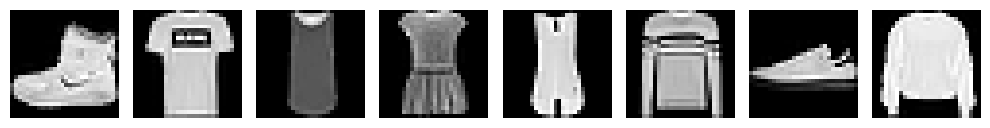

In [3]:
# Plotting a few images

fig, axes = plt.subplots(1, 8, figsize=(10, 2))

for i in range(8):
    ax = axes[i]
    ax.imshow(X_train[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Checking if the dataset is well balanced

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

print("labels of y_train")
print(dict(zip(*np.unique(y_train, return_counts=True))))
print("labels of y_test")
print(dict(zip(*np.unique(y_test, return_counts=True))))

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)
labels of y_train
{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
labels of y_test
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


# Defining the generative adversarial network

In [10]:
# Data reshape
X_train = np.reshape(X_train, (-1, 28, 28, 1))
X_test = np.reshape(X_test, (-1, 28, 28, 1))

### SETTING DIMENSIONS

latent_dim = 100

learning_rate = 0.0002

### GENERATOR

generator_input = keras.Input(shape=(latent_dim,))
x = generator_input

x = Dense(7 * 7 * 128, use_bias=False)(x)
x = Reshape((7, 7, 128))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.01)(x) # added

x = Conv2DTranspose(64, kernel_size=5, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.01)(x)

x = Conv2DTranspose(1, kernel_size=5, strides=2, padding="same")(x)
x = Activation("tanh")(x)

generator_output = x
generator = Model(generator_input, generator_output, name="generator")
generator.summary()

### DISCRIMINATOR

discriminator_input = keras.Input(shape=(28, 28, 1))
x = discriminator_input

x = Conv2D(64, kernel_size=5, strides=2, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.4)(x)

x = Conv2D(128, kernel_size=5, strides=2, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(1, activation="sigmoid")(x)

discriminator_output = x
discriminator = Model(discriminator_input, discriminator_output, name="discriminator")
discriminator.summary()

discriminator.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=learning_rate, beta_1=0.5),
    metrics=["accuracy"]
)

### GAN

discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))

gan = Model(gan_input, gan_output, name="gan")
gan.summary()

gan.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=learning_rate, beta_1=0.5),
    metrics=["accuracy"]
)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6272)           │       627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 834,433 (3.18 MB)

 Trainable params: 834,049 (3.18 MB)

 Non-trainable params: 384 (1.50 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator (Functional)          │ (None, 28, 28, 1)      │       834,433 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Functional)      │ (None, 1)              │       212,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,047,298 (4.00 MB)

 Trainable params: 834,049 (3.18 MB)

 Non-trainable params: 213,249 (833.00 KB)

# Training

Loaded saved model, continuing training...
Epoch 1/3 [D loss: 0.6690, acc.: 58.71%] [G loss: 0.7830, acc.: 39.40%]


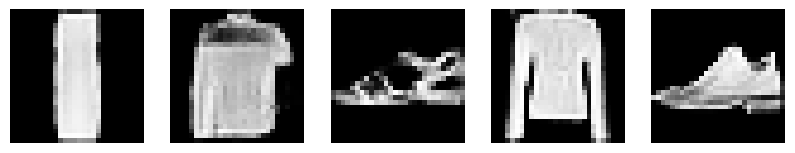

Epoch 2/3 [D loss: 0.6682, acc.: 58.81%] [G loss: 0.7838, acc.: 39.12%]


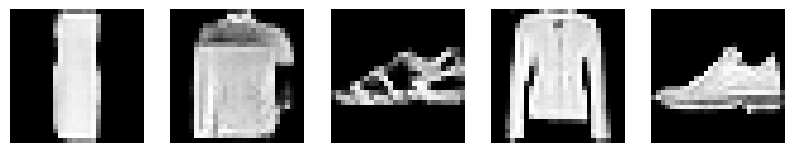

Epoch 3/3 [D loss: 0.6677, acc.: 58.91%] [G loss: 0.7861, acc.: 38.78%]


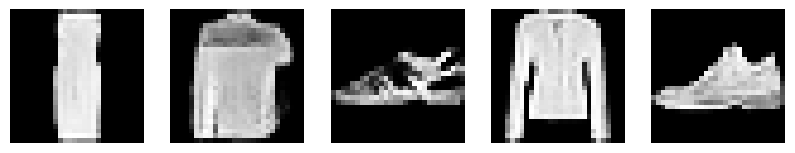

In [12]:
train = True # Change to True to train, and to False to load trained model

batch_size = 32 # 32
noise_const = np.random.normal(0, 1, (25, latent_dim))
epochs = 3

try: # Try loading existing model   
    # Load generator and discriminator
    generator = load_model("generator.keras")
    discriminator = load_model("discriminator.keras", compile=False)

    # Set discriminator trainable for its own training
    discriminator.trainable = True
    discriminator.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate, beta_1=0.5),
        metrics=['accuracy']
    )

    # Set discriminator non-trainable for GAN training
    discriminator.trainable = False

    # Reconnect models manually to create GAN
    z = Input(shape=(latent_dim,))
    img = generator(z)
    validity = discriminator(img)

    gan = Model(z, validity)
    gan.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate, beta_1=0.5),
        metrics=['accuracy']
    )
    
    print("Loaded saved model, continuing training...")
except Exception as e:
    print("No saved model found. Starting from scratch.")
    traceback.print_exc()

def sample_images(generator, noise_const = None):
    rows = 1
    columns = 5
    if noise_const is None:
        noise = np.random.normal(0, 1, (rows * columns, latent_dim))
    else:
        noise = noise_const
    generated_images = generator.predict(noise, verbose=0)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(rows, columns, figsize=(columns * 2, rows * 2))
    axs = np.atleast_2d(axs)

    count = 0
    for i in range(rows):
        for j in range(columns):
            axs[i, j].imshow(generated_images[count, :, :, 0], cmap="gray")
            axs[i, j].axis("off")
            count += 1
    plt.show()

if train:
    for epoch in range(epochs):
        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1000)
        dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)
        for X_batch in dataset:
            # training the discriminator
            discriminator.trainable = True
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generated_images = generator.predict(noise, verbose=0) # 
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            d_loss = discriminator.train_on_batch(X_fake_and_real, labels)
            # training the generator
            discriminator.trainable = False
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            labels = tf.constant([[1.]] * batch_size)
            g_loss = gan.train_on_batch(noise, labels)

        print(f"Epoch {epoch+1}/{epochs} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss[0]:.4f}, acc.: {100*g_loss[1]:.2f}%]")
        sample_images(generator, noise_const)

    generator.save(f"generator.keras")
    discriminator.save(f"discriminator.keras")
    gan.save(f"gan.keras")
else:
    sample_images(generator, noise_const)

# Final thoughts

The generated images show noticeably more detail than those produced by the VAE, but this comes at the cost of a larger model and significantly longer training. During training, both the generator and discriminator saw declining accuracy, though at different rates, indicating that the generator was learning to better fool the discriminator. Despite training for around 100 epochs with low learning rates (starting at 0.0002 and decreasing to 0.0001), the model did not approach the equilibrium where both networks would reach around 50% accuracy.

In [9]:
generator.save(f"generator.keras")
discriminator.save(f"discriminator.keras")
gan.save(f"gan.keras")